In [86]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#set display parameters
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [87]:
# import datafiles
training = pd.read_csv("kc_house_data_train.csv", index_col = 0)
holdout = pd.read_csv("kc_house_data_test_features.csv", index_col = 0)
imputed = pd.read_csv("bedroomsfilled.csv", index_col = 0)
extra = pd.read_csv("zip_code_extra_data_fixed.csv", index_col = 0)
date = pd.read_csv("date.csv", index_col = 0)

### Checking out the Sales dataframe

In [88]:
print(training.shape) #training and testing df to create a model for prediction
print(holdout.shape) #applying the model to predict the sales for the houses
print(imputed.shape) #missing data for 12 rows (no bedrooms)
print(extra.shape) # extra data on the 70 zipcodes from https://www.unitedstateszipcodes.org/
sales = training.copy()
sales.head()

(17290, 21)
(4323, 20)
(12, 21)
(70, 54)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [89]:
sales.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17285,627300195,20150303T000000,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400
17286,8819900270,20140520T000000,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013
17287,3816300095,20140514T000000,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403
17288,122069107,20141204T000000,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028
17289,6703100135,20150116T000000,348000.0,3,1.50,1330,6768,1.0,0,0,4,7,1330,0,1952,0,98155,47.7366,-122.319,1320,6910


In [90]:
date=pd.DataFrame(sales["date"])

In [91]:
# date.to_csv("date.csv")


In [92]:
sales.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [93]:
sales.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.729000e+04,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,4.565502e+09,5.407395e+05,3.372470,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824
std,2.874656e+09,3.733190e+05,0.939346,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,2.114701e+09,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000
50%,3.903650e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000
75%,7.301150e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000


In [94]:
corr = sales.corr()

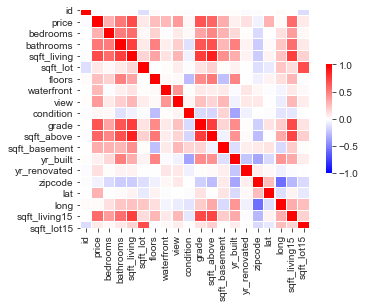

In [95]:
sns.heatmap(corr, cmap="bwr", vmax=1, vmin=-1, center=0, square = True,
             linewidths=.1, cbar_kws={"shrink": .5})

In [96]:

sales.drop(columns=["id","date"], inplace = True)

In [97]:
X = sales.drop(columns = "price")
y = sales.price

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
from sklearn import metrics

multi_lr_model = LinearRegression() # model

multi_lr_model.fit(X_train, y_train) # fit

y_pred = multi_lr_model.predict(X_test) # prediction

model_score = multi_lr_model.score(X_test,y_test)
r_square = metrics.r2_score(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.median_absolute_error(y_test, y_pred)
ev = metrics.explained_variance_score(y_test, y_pred)

print(model_score)
print(mse)
print("Mae: ",  mae)
print("R Square               : ", r_square)
print("Root Mean Squared Error: ", mse**(1/2))

0.7027786929887444
39547299966.78107
Mae:  85742.0843877308
R Square               :  0.7027786929887444
Root Mean Squared Error:  198865.02952198777


# Naive model: R_square of 0.702778 and RMSE of 198865.0295

In [14]:
def multicolinear_features(data):
    df=data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df['pairs'] = list(zip(df.level_0, df.level_1))
    df.set_index(['pairs'], inplace = True)
    df.drop(columns=['level_1', 'level_0'], inplace = True)
    df.columns = ['cc'] #correlation column
    df.drop_duplicates(inplace=True)
    return df[(df.cc>.75) & (df.cc<1) ]

multicolinear_features(sales) #checking for multicolinearity

,cc
pairs,
"(sqft_above, sqft_living)",0.876696
"(grade, sqft_living)",0.762929
"(sqft_above, grade)",0.758247
"(bathrooms, sqft_living)",0.755270
"(sqft_living15, sqft_living)",0.755066


In [15]:
sales[sales["bedrooms"]== 0]


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
483,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
1120,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
2430,265000.0,0,0.75,384,213444,1.0,0,0,3,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341
3032,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
3609,339950.0,0,2.50,2290,8319,2.0,0,0,3,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
5424,380000.0,0,0.00,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
6409,288000.0,0,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
9286,1295650.0,0,0.00,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
10067,142000.0,0,0.00,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
10074,240000.0,0,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685


In [16]:
sales["bedrooms"].max()

33

In [17]:
print(sales.shape, imputed.shape)

(17290, 19) (12, 21)


In [18]:
sales.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [98]:
imputed #dataframe with information on the missing bedrooms

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
483,3374500520,20150429T000000,355000.0,4,2.50,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
1120,6306400140,20140612T000000,1095000.0,5,3.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
2430,1222029077,20141029T000000,265000.0,1,0.75,384,213444,1.0,0,0,3,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341
3032,7849202190,20141223T000000,235000.0,3,2.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
3609,2569500210,20141117T000000,339950.0,4,3.00,2290,8319,2.0,0,0,3,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
5424,3918400017,20150205T000000,380000.0,3,2.50,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
6409,1453602309,20140805T000000,288000.0,2,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
9286,2954400190,20140624T000000,1295650.0,4,4.50,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
10067,3980300371,20140926T000000,142000.0,1,0.75,290,20875,1.0,0,0,1,1,290,0,1954,0,98024,47.5308,-121.888,1620,22850
10074,2310060040,20140925T000000,240000.0,4,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685


In [20]:
print(sales.shape, imputed.shape)

(17290, 19) (12, 21)


In [21]:
# sales["month"] = pd.DatetimeIndex(sales["date"]).month
# sales.drop(columns=["id","date"], inplace = True)
imputed.drop(columns=["id","date"], inplace = True)

In [22]:
imputed.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [23]:
imputed.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [24]:
print(sales.shape, imputed.shape)

(17290, 19) (12, 19)


# Merging Bedroom data for 12 rows and removing bedroom outliers

In [25]:
def filled_data(df,df2):
    index=df.loc[df.bedrooms == 0].index.to_list()
    df.drop(df.index[[index]], inplace=True)
    frames= [df, df2]
    train = pd.concat(frames)
    return train
sales=filled_data(sales, imputed)

In [26]:
print(sales.shape, imputed.shape)


(17290, 19) (12, 19)


In [27]:
# removes outliers - bedrooms  > 10

def cap_max(x, n, data, column):
    """
    x = the column number
    n = min number
    data = dataframe
    column = interested column from dataframe
    should be applied in a lambda function.
    For example: sales["bedrooms"].apply(lambda x: cutoff(x,10,sales,"bedrooms"))
    """
    if x > n:
        return data[column].median()
    else:
        return x
sales["bedrooms"]= sales["bedrooms"].apply(lambda x: cap_max(x,10,sales,"bedrooms"))    

In [28]:
sales.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,365000.0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,865000.0,5.0,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,1038000.0,4.0,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,1490000.0,3.0,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,711000.0,3.0,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [29]:
sales.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [30]:
multicolinear_features(sales)

,cc
pairs,
"(sqft_above, sqft_living)",0.876696
"(grade, sqft_living)",0.762929
"(sqft_above, grade)",0.758247
"(bathrooms, sqft_living)",0.756908
"(sqft_living15, sqft_living)",0.755066


In [99]:
multicolinear_features(sales.drop(columns = ["sqft_living", "sqft_above"]))

,cc
pairs,


# Checking the effect of the new data additions

In [100]:
X = sales.drop(columns = ["price", "sqft_living", "sqft_above"])
y = sales.price

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

multi_lr_model = LinearRegression() # model

multi_lr_model.fit(X_train, y_train) # fit

y_pred = multi_lr_model.predict(X_test) # prediction

model_score = multi_lr_model.score(X_test,y_test)
r_square = metrics.r2_score(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.median_absolute_error(y_test, y_pred)
ev = metrics.explained_variance_score(y_test, y_pred)

print(model_score)
print(mse)
print("Mae: ",  mae)
print("R Square               : ", r_square)
print("Root Mean Squared Error: ", mse**(1/2))

0.6704058521456662
43854724829.66142
Mae:  91004.83641060814
R Square               :  0.6704058521456662
Root Mean Squared Error:  209415.197227091


## R_square of 0.6906679 and RMSE of 209338.25106
#### Imputed information increased the data... interesting. 

# Adding More Data

In [34]:
training_data = pd.merge(sales, extra, how='right', on='zipcode')

In [35]:
training_data.shape

(17290, 73)

In [36]:
date

,date
0,20141006T000000
1,20140821T000000
2,20140815T000000
3,20150331T000000
4,20140714T000000
...,...
17285,20150303T000000
17286,20140520T000000
17287,20140514T000000
17288,20141204T000000


In [37]:
date.column = date

In [38]:
training_data = pd.merge(training_data, date, how = "outer", left_index=True, right_index=True)


In [39]:
training_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,full_time_earnings,part_time_earnings,no_earnings,car_truck_van,public_transportation,taxi,motorcycle,bike_walk_other,work_home,less_than_hs,high_school_grad,associates,bachelors,masters,professional_school_degree,doctorate,public_school_enrollment,private_school_enrollment,no_school_enrollment,for_rent,rented_and_unoccupied,for_sale_only,sold_and_unoccupied,seasonal_or_rec_use,migrant_worker_housing,vacant_other_reasons,in_occupied_housing_units,adult_correctional_facility,juvenile_facilities,nursing_facilities,other_institutional,military_quarters,other_noninstitutional,house_owned_with_mortgage,house_owned_outright,renter_occupied_housing,vacant_households,husband_and_wife_house,single_guardian,singles,singles_with_roommate,male,female,median_age,male_median_age,female_median_age,population,population_density_per_sq_mile,total_housing_units,median_home_value,land_area,water_area_sq_mile,occupied_housing_units,median_household_income,date
0,365000.0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,20141006T000000
1,455000.0,4.0,1.75,2050,94525,1.0,0,0,4,7,1250,800,1959,0,98058,47.4492,-122.084,2270,47480,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,20140821T000000
2,273000.0,3.0,1.75,2050,9045,2.0,0,0,4,6,2050,0,1959,0,98058,47.4572,-122.180,1200,9045,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,20140815T000000
3,223000.0,2.0,1.00,910,9869,1.0,0,0,3,6,910,0,1957,0,98058,47.4572,-122.184,1480,9750,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,20150331T000000
4,335500.0,5.0,3.00,2240,19090,1.0,0,0,4,8,1700,540,1968,0,98058,47.4416,-122.149,2280,20000,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,20140714T000000


In [40]:
training_data.shape

(17290, 74)

In [41]:
training_data["month"] = pd.DatetimeIndex(training_data["date"]).month
training_data.drop(columns=["date"], inplace = True)

In [42]:
training_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,full_time_earnings,part_time_earnings,no_earnings,car_truck_van,public_transportation,taxi,motorcycle,bike_walk_other,work_home,less_than_hs,high_school_grad,associates,bachelors,masters,professional_school_degree,doctorate,public_school_enrollment,private_school_enrollment,no_school_enrollment,for_rent,rented_and_unoccupied,for_sale_only,sold_and_unoccupied,seasonal_or_rec_use,migrant_worker_housing,vacant_other_reasons,in_occupied_housing_units,adult_correctional_facility,juvenile_facilities,nursing_facilities,other_institutional,military_quarters,other_noninstitutional,house_owned_with_mortgage,house_owned_outright,renter_occupied_housing,vacant_households,husband_and_wife_house,single_guardian,singles,singles_with_roommate,male,female,median_age,male_median_age,female_median_age,population,population_density_per_sq_mile,total_housing_units,median_home_value,land_area,water_area_sq_mile,occupied_housing_units,median_household_income,month
0,365000.0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,10
1,455000.0,4.0,1.75,2050,94525,1.0,0,0,4,7,1250,800,1959,0,98058,47.4492,-122.084,2270,47480,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,8
2,273000.0,3.0,1.75,2050,9045,2.0,0,0,4,6,2050,0,1959,0,98058,47.4572,-122.180,1200,9045,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,8
3,223000.0,2.0,1.00,910,9869,1.0,0,0,3,6,910,0,1957,0,98058,47.4572,-122.184,1480,9750,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,3
4,335500.0,5.0,3.00,2240,19090,1.0,0,0,4,8,1700,540,1968,0,98058,47.4416,-122.149,2280,20000,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,7


#### Checking the numbers again on the new Dataframe (TRAINING_DATA). 

In [43]:
X = training_data.drop(columns = "price")
y = training_data.price

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

multi_lr_model = LinearRegression() # model

multi_lr_model.fit(X_train, y_train) # fit

y_pred = multi_lr_model.predict(X_test) # prediction

model_score = multi_lr_model.score(X_test,y_test)
r_square = metrics.r2_score(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.median_absolute_error(y_test, y_pred)
ev = metrics.explained_variance_score(y_test, y_pred)

print(model_score)
print(mse)
print("Mae: ",  mae)
print("R Square               : ", r_square)
print("Root Mean Squared Error: ", mse**(1/2))

0.8044219596186032
23884251719.66544
Mae:  73080.89556531736
R Square               :  0.8044219596186032
Root Mean Squared Error:  154545.30636569147


# How do you improve from a R_square of 0.8044 and RMSE of 154545.306?
#### Conduct EDA and check for outliers. 

In [45]:
sales.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,5.407395e+05,3.372412,2.112854,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.791498,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824
std,3.733190e+05,0.906370,0.769820,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343734,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583
min,7.500000e+04,1.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000
max,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000


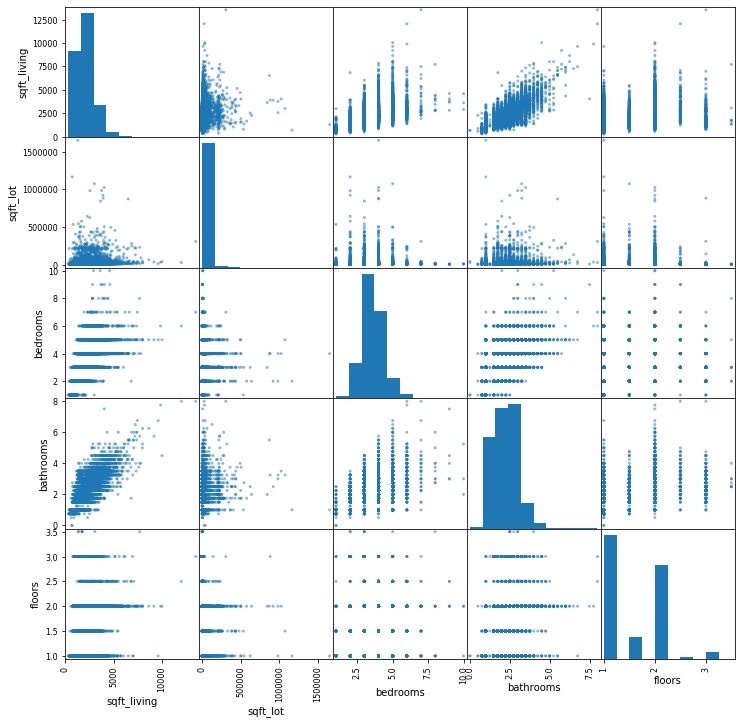

In [46]:
pd.plotting.scatter_matrix(sales[["sqft_living", "sqft_lot","bedrooms","bathrooms","floors"]],figsize  = (12, 12));
plt.show()

In [47]:
categorical =['bedrooms', 'view', 'waterfront', 'bathrooms', 'floors','condition',
              'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'month']

non_cat = ['sqft_living','sqft_lot','sqft_above', 'sqft_basement','sqft_living15', 'sqft_lot15']

target = "price"

predictor = "Mix of categorical and non categorical"

In [48]:
# with sns.plotting_context("notebook",font_scale=2.5):
#     g = sns.pairplot(sales, size=6)
# g.set(xticklabels=[]);

#### Check out Outliers

In [49]:
def cap_max(x, n, data, column):
    """
    x = the column number
    n = min number
    data = dataframe
    column = interested column from dataframe
    should be applied in a lambda function.
    
    For example: sales["bedrooms"].apply(lambda x: cutoff(x,10,sales,"bedrooms"))
    """
    if x > n:
        return data[column].median()
    else:
        return x
    

In [50]:
from geopy.distance import geodesic
downtown = (47.609862, -122.342056)
training_data['coords'] = tuple(zip(training_data['lat'],training_data['long']))
training_data['distance_from_downtown'] = training_data['coords'].apply(lambda x: geodesic(downtown,x))
training_data['distance_from_downtown'] = training_data['distance_from_downtown'].astype(str).str[:-3].astype(float)


In [51]:
training_data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,full_time_earnings,part_time_earnings,no_earnings,car_truck_van,public_transportation,taxi,motorcycle,bike_walk_other,work_home,less_than_hs,high_school_grad,associates,bachelors,masters,professional_school_degree,doctorate,public_school_enrollment,private_school_enrollment,no_school_enrollment,for_rent,rented_and_unoccupied,for_sale_only,sold_and_unoccupied,seasonal_or_rec_use,migrant_worker_housing,vacant_other_reasons,in_occupied_housing_units,adult_correctional_facility,juvenile_facilities,nursing_facilities,other_institutional,military_quarters,other_noninstitutional,house_owned_with_mortgage,house_owned_outright,renter_occupied_housing,vacant_households,husband_and_wife_house,single_guardian,singles,singles_with_roommate,male,female,median_age,male_median_age,female_median_age,population,population_density_per_sq_mile,total_housing_units,median_home_value,land_area,water_area_sq_mile,occupied_housing_units,median_household_income,month,coords,distance_from_downtown
0,365000.0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,10,"(47.4388, -122.162)",23.357742
1,455000.0,4.0,1.75,2050,94525,1.0,0,0,4,7,1250,800,1959,0,98058,47.4492,-122.084,2270,47480,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,8,"(47.4492, -122.084)",26.394534
2,273000.0,3.0,1.75,2050,9045,2.0,0,0,4,6,2050,0,1959,0,98058,47.4572,-122.180,1200,9045,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,8,"(47.4572, -122.18)",20.904034
3,223000.0,2.0,1.00,910,9869,1.0,0,0,3,6,910,0,1957,0,98058,47.4572,-122.184,1480,9750,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,3,"(47.4572, -122.184)",20.729671
4,335500.0,5.0,3.00,2240,19090,1.0,0,0,4,8,1700,540,1968,0,98058,47.4416,-122.149,2280,20000,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,7,"(47.4416, -122.149)",23.692559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,1950000.0,4.0,3.75,4150,17424,1.0,0,0,3,9,3130,1020,1963,2000,98039,47.6390,-122.236,3930,21420,807,385,953,890,34,0,0,40,57,12,290,68,922,388,146,51,555,355,32,13,0,32,9,19,0,28,2971,0,0,0,0,0,0,567,379,116,101,777,89,172,24,1468,1503,46,45,46,2971,2059,1163,1000001.0,1.44,4.30,1062,183833.0,3,"(47.639, -122.236)",8.604878
17286,2450000.0,7.0,4.25,4670,23115,2.0,0,2,3,11,4670,0,1992,0,98039,47.6183,-122.227,3240,13912,807,385,953,890,34,0,0,40,57,12,290,68,922,388,146,51,555,355,32,13,0,32,9,19,0,28,2971,0,0,0,0,0,0,567,379,116,101,777,89,172,24,1468,1503,46,45,46,2971,2059,1163,1000001.0,1.44,4.30,1062,183833.0,5,"(47.6183, -122.227)",8.700660
17287,2100000.0,4.0,1.75,3550,

In [55]:
corra=training_data.corr()

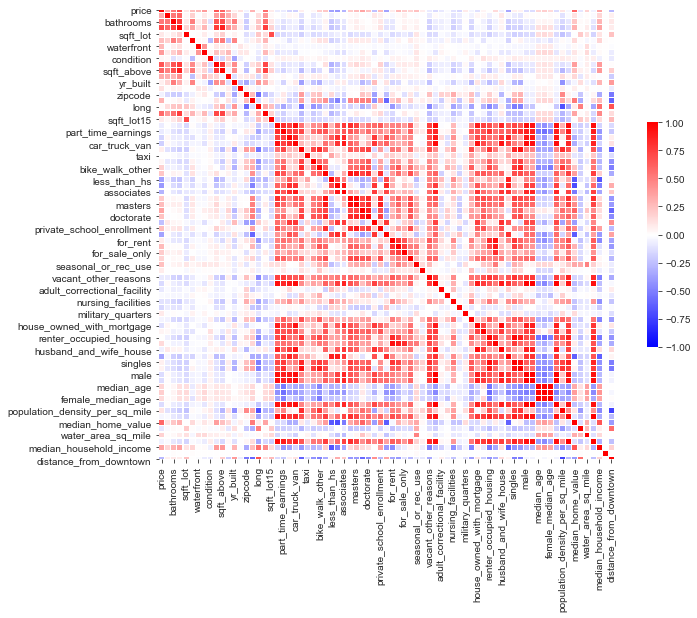

In [72]:

fig, ax = plt.subplots()

fig.set_size_inches(11.7, 8.27)


sns.heatmap(corra, cmap="bwr", vmax=1,vmin=-1, center=0, square = True,
             linewidths=.1, cbar_kws={"shrink": .5});

In [60]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 76 columns):
price                             17290 non-null float64
bedrooms                          17290 non-null float64
bathrooms                         17290 non-null float64
sqft_living                       17290 non-null int64
sqft_lot                          17290 non-null int64
floors                            17290 non-null float64
waterfront                        17290 non-null int64
view                              17290 non-null int64
condition                         17290 non-null int64
grade                             17290 non-null int64
sqft_above                        17290 non-null int64
sqft_basement                     17290 non-null int64
yr_built                          17290 non-null int64
yr_renovated                      17290 non-null int64
zipcode                           17290 non-null int64
lat                               17290 non-null float64
l

In [61]:
training_data.drop(columns = "coords", inplace = True)

In [62]:
X = training_data.drop(columns = "price")
y = training_data.price

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

multi_lr_model = LinearRegression() # model

multi_lr_model.fit(X_train, y_train) # fit

y_pred = multi_lr_model.predict(X_test) # prediction

# model_score = multi_lr_model.score(X_test,y_test)
r_square = metrics.r2_score(y_test, y_pred)
# mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.median_absolute_error(y_test, y_pred)
# ev = metrics.explained_variance_score(y_test, y_pred)

# print(model_score)
# print(mse)
# print("Mae: ",  mae)
print("R Square               : ", r_square)
print("Root Mean Squared Error: ", mse**(1/2))

R Square               :  0.6704058521456662
Root Mean Squared Error:  209415.197227091


##### It was R_square of 0.8044 and RMSE of 154545.306
##### Imporved by a little: R_square of 0.804879 and RMSE of 154364.50 

# Statistics to Determine the features

In [82]:
training_data["house_years"] = abs(training_data["yr_renovated"]-training_data["yr_built"])

training_data["house_age_2015"] = 2015 - training_data["yr_built"] # age of the house by 25 with or without renovation. 

In [85]:
training_data.shape

(17290, 77)

In [103]:
training_data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,full_time_earnings,part_time_earnings,no_earnings,car_truck_van,public_transportation,taxi,motorcycle,bike_walk_other,work_home,less_than_hs,high_school_grad,associates,bachelors,masters,professional_school_degree,doctorate,public_school_enrollment,private_school_enrollment,no_school_enrollment,for_rent,rented_and_unoccupied,for_sale_only,sold_and_unoccupied,seasonal_or_rec_use,migrant_worker_housing,vacant_other_reasons,in_occupied_housing_units,adult_correctional_facility,juvenile_facilities,nursing_facilities,other_institutional,military_quarters,other_noninstitutional,house_owned_with_mortgage,house_owned_outright,renter_occupied_housing,vacant_households,husband_and_wife_house,single_guardian,singles,singles_with_roommate,male,female,median_age,male_median_age,female_median_age,population,population_density_per_sq_mile,total_housing_units,median_home_value,land_area,water_area_sq_mile,occupied_housing_units,median_household_income,month,distance_from_downtown,house_years,house_age_2015
0,365000.0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,10,23.357742,1986,29
1,455000.0,4.0,1.75,2050,94525,1.0,0,0,4,7,1250,800,1959,0,98058,47.4492,-122.084,2270,47480,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,8,26.394534,1959,56
2,273000.0,3.0,1.75,2050,9045,2.0,0,0,4,6,2050,0,1959,0,98058,47.4572,-122.180,1200,9045,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,8,20.904034,1959,56
3,223000.0,2.0,1.00,910,9869,1.0,0,0,3,6,910,0,1957,0,98058,47.4572,-122.184,1480,9750,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,3,20.729671,1957,58
4,335500.0,5.0,3.00,2240,19090,1.0,0,0,4,8,1700,540,1968,0,98058,47.4416,-122.149,2280,20000,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,7,23.692559,1968,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,1950000.0,4.0,3.75,4150,17424,1.0,0,0,3,9,3130,1020,1963,2000,98039,47.6390,-122.236,3930,21420,807,385,953,890,34,0,0,40,57,12,290,68,922,388,146,51,555,355,32,13,0,32,9,19,0,28,2971,0,0,0,0,0,0,567,379,116,101,777,89,172,24,1468,1503,46,45,46,2971,2059,1163,1000001.0,1.44,4.30,1062,183833.0,3,8.604878,37,52
17286,2450000.0,7.0,4.25,4670,23115,2.0,0,2,3,11,4670,0,1992,0,98039,47.6183,-122.227,3240,13912,807,385,953,890,34,0,0,40,57,12,290,68,922,388,146,51,555,355,32,13,0,32,9,19,0,28,2971,0,0,0,0,0,0,567,379,116,101,777,89,172,24,1468,1503,46,45,46,2971,2059,1163,1000001.0,1.44,4.30,1062,183833.0,5,8.700660,1992,23
17287,2100000.0,4.0,1.75,3550,19865,2.0,0,0,3,9,3550,0,1962,2002,98039,47.6236,-122.235,3000,19862,807,3